In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Сегодня мы будем предсказывать популярность объявления о продаже недвижимости

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df

,Id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,TARGET
0,57094,1.0,3,0,2016-05-19 18:06:27,A FABULOUS 3BR IN MIDTOWN WEST! PERFECT APAR...,HOW AMAZING IS THIS MIDTOWN WEST STEAL!! NO FE...,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,7039994,-73.9918,4bdc3d8c1aaa90d997ce2cb77680679b,['https://photos.renthop.com/2/7039994_07be01b...,4495,W 50 & AVE 10,medium
1,33389,1.0,1,9225efdfb57a50bf3ec17ebab082f94a,2016-06-16 02:01:49,Renovated Kitchen and Bathroom!,55 River Drive South,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,7166774,-74.0322,e5808a5e6cc13988fe596704428d38d5,['https://photos.renthop.com/2/7166774_03cf63a...,2570,55 River Drive South,medium
2,60458,1.0,0,320de7d3cc88e50a7fbbcfde1e825d21,2016-05-04 02:42:50,RARE AND BEST DEAL ON THE MARKET!!!! PERFECT S...,W 77 Street,"['Elevator', 'Hardwood Floors']",40.7798,6962716,-73.9751,d69d4e111612dd12ef864031c1148543,['https://photos.renthop.com/2/6962716_ec7f56f...,1795,22 W 77 Street,low
3,53048,1.0,2,ce6d18bf3238e668b2bf23f4110b7b67,2016-05-12 05:57:56,Newly renovated flex 2 apartment offers the ne...,John Street,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,7002458,-74.0065,e6472c7237327dd3903b3d6f6a94515a,['https://photos.renthop.com/2/7002458_93f4010...,3400,100 John Street,low
4,592,1.0,3,fee4d465932160318364d9d48d272879,2016-06-16 06:06:15,LOW FEE apartments do not come around like thi...,West 16th Street,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,7170465,-74.0025,6fba9b3a8327c607b8b043716efee684,['https://photos.renthop.com/2/7170465_9c3f173...,5695,321 West 16th Street,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34541,25582,1.0,1,14fdc4b01ae44b025f6c4d28c9097e5f,2016-06-16 02:12:57,Newly renovated bedroom apartment located off ...,29th St,['No pets'],40.7653,7166867,-73.9248,e6472c7237327dd3903b3d6f6a94515a,['https://photos.renthop.com/2/7166867_625fde3...,1950,30-95 29th St,low
34542,50013,1.0,0,9b6cf886379a2511f8c633c84028efe7,2016-05-10 03:17:32,All apartments are newly renovated featuring: ...,E 1st St,"['Pre-War', 'Laundry in Unit', 'Dishwasher', '...",40.7239,6989251,-73.9901,5599e962719af3ccc2976855c2d5893c,['https://photos.renthop.com/2/6989251_42a4884...,2600,39 E 1st St,medium
34543,111475,2.0,2,0,2016-04-21 03:29:35,"<![CDATA[2 bedrooms, 5110, Astoria / Long Isla...",50th Avenue,[],40.7437,6905568,-73.9585,e6472c7237327dd3903b3d6f6a94515a,['https://photos.renthop.com/2/6905568_01602e3...,5110,2-01 50th Avenue,low
34544,71184,1.0,2,8754cae39f6e053974aa2337017eb3c1,2016-05-14 02:27:47,CooperCooper.com :: Listing ID #10_0385; 400 W...,400 West 56th Street,"['Laundry in Unit', 'Dishwasher', 'Cats Allowe...",40.7673,7010187,-73.9866,6e5c10246156ae5bdcd9b487ca99d96a,['https://photos.renthop.com/2/7010187_ab1db5d...,3400,400 West 56th Street,medium


In [4]:
df.nunique()

Id                 34546
bathrooms             12
bedrooms               8
building_id         6378
created            34186
description        27757
display_address     6998
features            8245
latitude            2182
listing_id         34546
longitude           1566
manager_id          3134
photos             31992
price               2407
street_address     12398
TARGET                 3
dtype: int64

In [5]:
df.isna().sum()

Id                    0
bathrooms             0
bedrooms              0
building_id           0
created               0
description        1037
display_address      88
features              0
latitude              0
listing_id            0
longitude             0
manager_id            0
photos                0
price                 0
street_address        4
TARGET                0
dtype: int64

In [6]:
df.fillna("", inplace=True) # заменим пропущенные строковые значения пустой строкой

In [7]:
df[df['building_id'] == '0'].shape[0] # как и ожидалось, в категориальных фичах тоже есть нули

5713

In [8]:
# обработаем айди недвижимости и менеджеров

df['building_id'] = df['building_id'].astype('category').cat.rename_categories([i for i in range(df['building_id'].nunique())]).astype('int')
df['manager_id'] = df['manager_id'].astype('category').cat.rename_categories([i for i in range(df['manager_id'].nunique())]).astype('int')


In [9]:
# Таймстепы разобьём на месяц, день и час (вдруг мы выясним, что популярные объявления постятся в конкретный сезон/день/час)

df['created_month'] = pd.to_datetime(df.created).apply(lambda x: x.month)
df['created_day'] = pd.to_datetime(df.created).apply(lambda x: x.day)
df['created_hour'] = pd.to_datetime(df.created).apply(lambda x: x.hour)
df.drop('created', axis=1, inplace=True)


In [10]:
import ast
# возьмём количество фотографий как фичу (ссылки на фото всё равно недоступны..)

df['photos'] = df['photos'].apply(lambda x: len(ast.literal_eval(x)))


In [11]:
df['photos']

0         3
1        13
2         6
3         4
4         3
         ..
34541     4
34542     6
34543    15
34544     3
34545     4
Name: photos, Length: 34546, dtype: int64

In [12]:
import re

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from functools import lru_cache



def tokenize(text: str, regex="[A-Za-z0-9]+") -> list: # будем токенизировать с помощью регулярки
    regex = re.compile(regex)
    tokens = regex.findall(text.lower())

    return tokens

def remove_stopwords(
    lemmas, stopwords=stopwords.words("english")):
    """Returns list of lemmas without stopwords"""
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

@lru_cache(maxsize=128) # ускорим лемматизацию кэшированием 
def lemmatize_word(token):
    """Returns lemma"""
    stemmer = PorterStemmer() # поскольку у нас английский текст будет достаточно найти стемму каждого слова
    return stemmer.stem(token)

def lemmatize_text(text):
    """Returns list of lemmas"""
    return [lemmatize_word(w) for w in text]

def clean_text(text):
    """Returns list of lemmas without stopwords"""
    tokens = tokenize("".join(text))
    lemmas = lemmatize_text(tokens)

    return remove_stopwords(lemmas)

In [13]:
from multiprocess import Pool # распараллелим процессы

def get_clean_text(df):
    with Pool(8) as p:
        review_lemmas = list(p.imap(clean_text, df))
    return review_lemmas

In [14]:
df['features'].apply(lambda x: ast.literal_eval(x)).explode().nunique() # я полагал, что "особенности" строго определены и мы их за-one-hot-encodi-им, 
                                                                        #  но их что-то многовато

1247

In [15]:
df['features'] = df['features'].apply(lambda x: " ".join(ast.literal_eval(x))) # раскроем списки 


In [16]:
# сольём ячейки с описанием и особенностями недвижимости в одну, то же проделаем с адресом
# я думаю, что резонно использовать два отдельных эмбединга для каждого из получившихся столбцов, 
# так как может получиться, что, например, пиарить фичи в адресе не особо эффективно и отпугивает клиентов или же наоборот

df['features_and_description'] = df['features'] + " " + df['description'] 
df['address'] = df['display_address'] + " " + df['street_address']
df.drop(['display_address', 'street_address', 'features', 'description', "Id"], axis=1, inplace=True)

In [17]:
df

,bathrooms,bedrooms,building_id,latitude,listing_id,longitude,manager_id,photos,price,TARGET,created_month,created_day,created_hour,features_and_description,address
0,1.0,3,0,40.7647,7039994,-73.9918,930,3,4495,medium,5,19,18,Laundry In Unit No Fee Elevator A FABULOUS 3BR...,HOW AMAZING IS THIS MIDTOWN WEST STEAL!! NO FE...
1,1.0,1,3623,40.7275,7166774,-74.0322,2804,13,2570,medium,6,16,2,Dogs Allowed Cats Allowed No Fee Renovated Kit...,55 River Drive South 55 River Drive South
2,1.0,0,1209,40.7798,6962716,-73.9751,2641,6,1795,low,5,4,2,Elevator Hardwood Floors RARE AND BEST DEAL ON...,W 77 Street 22 W 77 Street
3,1.0,2,5152,40.7081,7002458,-74.0065,2816,4,3400,low,5,12,5,Swimming Pool Doorman Elevator Fitness Center ...,John Street 100 John Street
4,1.0,3,6341,40.7416,7170465,-74.0025,1373,3,5695,low,6,16,6,Laundry in Building Laundry in Unit Dishwasher...,West 16th Street 321 West 16th Street
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34541,1.0,1,504,40.7653,7166867,-73.9248,2816,4,1950,low,6,16,2,No pets Newly renovated bedroom apartment loca...,29th St 30-95 29th St
34542,1.0,0,3876,40.7239,6989251,-73.9901,1051,6,2600,medium,5,10,3,Pre-War Laundry in Unit Dishwasher Hardwood Fl...,E 1st St 39 E 1st St
34543,2.0,2,0,40.7437,6905568,-73.9585,2816,15,5110,low,4,21,3,"<![CDATA[2 bedrooms, 5110, Astoria / Long Isl...",50th Avenue 2-01 50th Avenue
34544,1.0,2,3350,40.7673,7010187,-73.9866,1357,3,3400,medium,5,14,2,Laundry in Unit Dishwasher Cats Allowed Dogs A...,400 West 56th Street 400 West 56th Street


In [18]:
# предобработаем текст новых колонок

df['features_and_description'] = get_clean_text(df['features_and_description'])
df['address'] = get_clean_text(df['address'])

In [19]:
df['features_and_description'] = df['features_and_description'].apply(lambda x: " ".join(x))
df['address'] = df['address'].apply(lambda x: " ".join(x))

**Добавим новую фичу -- количество слов положительной тональности на общее количество слов в описании***

In [20]:
with open("positive-words.txt", "r") as file:
    pos_wordlist = file.readlines()

In [21]:
def emotions_words_ratio(lst):
    pos_words = 0
    for word in lst:
        if word in " ".join(pos_wordlist):
            pos_words += 1
    if len(lst):
        return pos_words / len(lst)
    else:
        return 0.0

In [22]:
df['positive words ratio'] = df['features_and_description'].apply(lambda x: emotions_words_ratio(x.split()))

In [23]:
df

,bathrooms,bedrooms,building_id,latitude,listing_id,longitude,manager_id,photos,price,TARGET,created_month,created_day,created_hour,features_and_description,address,positive words ratio
0,1.0,3,0,40.7647,7039994,-73.9918,930,3,4495,medium,5,19,18,laundri unit elev fabul midtown west perfect a...,amaz midtown west steal,0.452381
1,1.0,1,3623,40.7275,7166774,-74.0322,2804,13,2570,medium,6,16,2,allow allow renov kitchen bathroom,river drive south river drive south,0.400000
2,1.0,0,1209,40.7798,6962716,-73.9751,2641,6,1795,low,5,4,2,elev hardwood floor rare best deal market perf...,street street,0.343750
3,1.0,2,5152,40.7081,7002458,-74.0065,2816,4,3400,low,5,12,5,swim pool doorman elev center laundri unit dis...,john street john street,0.313043
4,1.0,3,6341,40.7416,7170465,-74.0025,1373,3,5695,low,6,16,6,laundri build laundri unit dishwash hardwood f...,west 16th street west 16th street,0.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34541,1.0,1,504,40.7653,7166867,-73.9248,2816,4,1950,low,6,16,2,newli renov bedroom apart locat 30th avenu tra...,29th 29th,0.250000
34542,1.0,0,3876,40.7239,6989251,-73.9901,1051,6,2600,medium,5,10,3,laundri unit dishwash hardwood floor outdoor s...,,0.212766
34543,2.0,2,0,40.7437,6905568,-73.9585,2816,15,5110,low,4,21,3,cdata bedroom 5110 astoria long island citi lu...,50th avenu 50th avenu,0.243243
34544,1.0,2,3350,40.7673,7010187,-73.9866,1357,3,3400,medium,5,14,2,laundri unit dishwash allow allow coopercoop l...,west 56th street west 56th street,0.298387


In [24]:
# почистим датасет от выбросов

print(df.price[df['price'] > 20000])
print(df.latitude[df['latitude'] > 40])
print(df.longitude[df['longitude'] > -70])

457        25000
912        24000
1047     4490000
1151       30000
1288       25000
          ...   
33955      29000
34015      25000
34086      50000
34340      21000
34346      26500
Name: price, Length: 72, dtype: int64
0        40.7647
1        40.7275
2        40.7798
3        40.7081
4        40.7416
          ...   
34541    40.7653
34542    40.7239
34543    40.7437
34544    40.7673
34545    40.7765
Name: latitude, Length: 34538, dtype: float64
308      0.0
7234     0.0
10426    0.0
20352    0.0
24090    0.0
27868    0.0
28855    0.0
33373    0.0
Name: longitude, dtype: float64


In [25]:

df.drop(df.price[df['price'] > 20000].index, axis=0, inplace=True)
df.drop(df.latitude[df['latitude'] < 40].index, axis=0, inplace=True)
df.drop(df.longitude[df['longitude'] > -70].index, axis=0, inplace=True)


In [26]:
df.longitude[df['longitude'] > -70]


Series([], Name: longitude, dtype: float64)

In [27]:
df['TARGET'].value_counts().index

Index(['low', 'medium', 'high'], dtype='object')

**Посмотрим на распределения некоторых фич**

In [28]:
fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'},]])

fig.add_trace(go.Pie(values=df['bathrooms'].value_counts(), labels=df['bathrooms'].value_counts().index,  name="Bathrooms"), 1, 1)
fig.add_trace(go.Pie(values=df['bedrooms'].value_counts(), labels=df['bedrooms'].value_counts().index, name="Bedrooms"), 1, 2)
fig.add_trace(go.Pie(values=df['TARGET'].value_counts(), labels=df['TARGET'].value_counts().index, name="Popularity"), 1, 3)
fig.update_traces(hole=.4)
fig.update_layout(
    title_text="Pie distribution",

    annotations=[dict(text='Bathrooms', x=0.11, y=0.5, font_size=14, showarrow=False),
                 dict(text='Bedrooms', x=0.50, y=0.5, font_size=14, showarrow=False),
                 dict(text='Target', x=0.88, y=0.5, font_size=14, showarrow=False)],
    showlegend=False)
fig.show()

In [29]:
fig = make_subplots(rows=1, cols=5)

fig.add_trace(go.Histogram(x=df['latitude'],  name="Latitude"), 1, 1)
fig.add_trace(go.Histogram(x=df['longitude'], name="Longitude"), 1, 2)
fig.add_trace(go.Histogram(x=df['price'], name="Price"), 1, 3)
fig.add_trace(go.Histogram(x=df['photos'], name="Photos"), 1, 4)
fig.add_trace(go.Histogram(x=df['positive words ratio'], name="Positive words ratio"), 1, 5)
fig.update_layout(title_text="Histogram distribution")
fig.show()

**В целом, грустный только таргет, с таким дисбалансом вряд ли модель будет хорошо справляться с обнаружением меньших классов**

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


In [31]:
df.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'latitude', 'listing_id',
       'longitude', 'manager_id', 'photos', 'price', 'TARGET', 'created_month',
       'created_day', 'created_hour', 'features_and_description', 'address',
       'positive words ratio'],
      dtype='object')

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("TARGET", axis=1), df['TARGET'], test_size=0.2, random_state=42)

In [33]:
tfidf = TfidfVectorizer()

X_train_address, X_test_address = tfidf.fit_transform(X_train['address']), tfidf.transform(X_test['address']) 
X_train_description, X_test_description = tfidf.fit_transform(X_train['features_and_description']), tfidf.transform(X_test['features_and_description'])
X_train, X_test = X_train.drop(['features_and_description', 'address'], axis=1), X_test.drop(['features_and_description', 'address'], axis=1)

In [34]:
X_train_address.toarray() # преобразовали два наших текстовых столбика в векторы

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [35]:
import numpy as np

# соединим всё в один датасет

X_train, X_test = np.hstack([X_train_address.toarray(), X_train_description.toarray(), X_train]), np.hstack(
                            [X_test_address.toarray(), X_test_description.toarray(), X_test])

In [36]:
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier

catclf = CatBoostClassifier()


In [37]:
catclf.fit(X_train, y_train)

Learning rate set to 0.09371
0:	learn: 1.0343542	total: 520ms	remaining: 8m 39s
1:	learn: 0.9843361	total: 777ms	remaining: 6m 27s
2:	learn: 0.9427321	total: 969ms	remaining: 5m 22s
3:	learn: 0.9093622	total: 1.18s	remaining: 4m 52s
4:	learn: 0.8814319	total: 1.39s	remaining: 4m 36s
5:	learn: 0.8560587	total: 1.63s	remaining: 4m 30s
6:	learn: 0.8358720	total: 1.84s	remaining: 4m 21s
7:	learn: 0.8200420	total: 2.04s	remaining: 4m 13s
8:	learn: 0.8024787	total: 2.27s	remaining: 4m 10s
9:	learn: 0.7873571	total: 2.55s	remaining: 4m 12s
10:	learn: 0.7747088	total: 2.77s	remaining: 4m 8s
11:	learn: 0.7619552	total: 3s	remaining: 4m 6s
12:	learn: 0.7534395	total: 3.22s	remaining: 4m 4s
13:	learn: 0.7458691	total: 3.42s	remaining: 4m 1s
14:	learn: 0.7371720	total: 3.62s	remaining: 3m 57s
15:	learn: 0.7297648	total: 3.84s	remaining: 3m 56s
16:	learn: 0.7226170	total: 4.04s	remaining: 3m 53s
17:	learn: 0.7182159	total: 4.24s	remaining: 3m 51s
18:	learn: 0.7124619	total: 4.47s	remaining: 3m 50s


In [38]:
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

In [39]:
preds = catclf.predict(X_test)

In [40]:
print(classification_report(y_test, preds))
print("full data balanced accuracy", balanced_accuracy_score(y_test, preds))

              precision    recall  f1-score   support

        high       0.67      0.17      0.27       546
         low       0.78      0.94      0.85      4760
      medium       0.46      0.29      0.35      1588

    accuracy                           0.73      6894
   macro avg       0.63      0.46      0.49      6894
weighted avg       0.69      0.73      0.69      6894

full data balanced accuracy 0.46443905857893114


**полнота ожидаемо плоха, целевая метрика тоже грустит. Попробуем воспользоваться техникой андерсемплинга и обрезать наш датасет до условного баланса**

In [41]:
df2 = pd.concat([df.sort_values(by='TARGET')[32000:],df.sort_values(by='TARGET')[:5000]],  axis=0)

In [42]:
df2.TARGET.value_counts()

high      2687
medium    2466
low       2313
Name: TARGET, dtype: int64

In [43]:
X_train, X_test, y_train, y_test = train_test_split(df2.drop("TARGET", axis=1), df2['TARGET'], test_size=0.2, random_state=42)

In [44]:
X_train_address, X_test_address = tfidf.fit_transform(X_train['address']), tfidf.transform(X_test['address'])
X_train_description, X_test_description = tfidf.fit_transform(X_train['features_and_description']), tfidf.transform(X_test['features_and_description'])
X_train, X_test = X_train.drop(['features_and_description', 'address'], axis=1), X_test.drop(['features_and_description', 'address'], axis=1)

In [45]:
X_train, X_test = np.hstack([X_train_address.toarray(), X_train_description.toarray(), X_train]), np.hstack([X_test_address.toarray(), X_test_description.toarray(), X_test])

In [46]:
catclf2 = CatBoostClassifier()
catclf2.fit(X_train, y_train)

Learning rate set to 0.086677
0:	learn: 1.0842971	total: 149ms	remaining: 2m 29s
1:	learn: 1.0716848	total: 233ms	remaining: 1m 56s
2:	learn: 1.0581374	total: 313ms	remaining: 1m 44s
3:	learn: 1.0461051	total: 399ms	remaining: 1m 39s
4:	learn: 1.0369773	total: 480ms	remaining: 1m 35s
5:	learn: 1.0272260	total: 561ms	remaining: 1m 32s
6:	learn: 1.0200722	total: 640ms	remaining: 1m 30s
7:	learn: 1.0098621	total: 724ms	remaining: 1m 29s
8:	learn: 1.0046085	total: 801ms	remaining: 1m 28s
9:	learn: 0.9987163	total: 880ms	remaining: 1m 27s
10:	learn: 0.9926466	total: 963ms	remaining: 1m 26s
11:	learn: 0.9890368	total: 1.04s	remaining: 1m 25s
12:	learn: 0.9820369	total: 1.12s	remaining: 1m 25s
13:	learn: 0.9764656	total: 1.21s	remaining: 1m 24s
14:	learn: 0.9729046	total: 1.28s	remaining: 1m 24s
15:	learn: 0.9681138	total: 1.36s	remaining: 1m 23s
16:	learn: 0.9645147	total: 1.44s	remaining: 1m 23s
17:	learn: 0.9595066	total: 1.53s	remaining: 1m 23s
18:	learn: 0.9558998	total: 1.61s	remaining:

In [47]:
undersample_preds = catclf2.predict(X_test)

In [48]:
print(classification_report(y_test, undersample_preds))
print("undersample balanced accuracy", balanced_accuracy_score(y_test, undersample_preds))


              precision    recall  f1-score   support

        high       0.59      0.70      0.64       515
         low       0.63      0.62      0.63       454
      medium       0.46      0.38      0.42       525

    accuracy                           0.57      1494
   macro avg       0.56      0.57      0.56      1494
weighted avg       0.56      0.57      0.56      1494

undersample balanced accuracy 0.5697182558351884


**Чтож, целевая метрика выросла, как и полнота... будем думать об этом**

In [49]:
df_test = pd.read_csv('test.csv')

In [50]:
df_test.isna().sum()

Id                   0
bathrooms            0
bedrooms             0
building_id          0
created              0
description        409
display_address     47
features             0
latitude             0
listing_id           0
longitude            0
manager_id           0
photos               0
price                0
street_address       6
dtype: int64

**Предобработаем наш тестовый датасет**

In [51]:
df_test.fillna("", inplace=True)

df_test['building_id'] = df_test['building_id'].astype('category').cat.rename_categories([i for i in range(df_test['building_id'].nunique())]).astype('int')
df_test['manager_id'] = df_test['manager_id'].astype('category').cat.rename_categories([i for i in range(df_test['manager_id'].nunique())]).astype('int')

df_test['created_month'] = pd.to_datetime(df_test.created).apply(lambda x: x.month)
df_test['created_day'] = pd.to_datetime(df_test.created).apply(lambda x: x.day)
df_test['created_hour'] = pd.to_datetime(df_test.created).apply(lambda x: x.hour)
df_test.drop('created', axis=1, inplace=True)

df_test['photos'] = df_test['photos'].apply(lambda x: len(ast.literal_eval(x)))
df_test['features'] = df_test['features'].apply(lambda x: " ".join(ast.literal_eval(x)))
df_test['address'] = df_test['display_address'] + " " + df_test['street_address']


df_test['features_and_description'] = df_test['features'] + " " + df_test['description']

df_test['features_and_description'] = get_clean_text(df_test['features_and_description'])
df_test['address'] = get_clean_text(df_test['address'])

df_test['features_and_description'] = df_test['features_and_description'].apply(lambda x: " ".join(x))
df_test['address'] = df_test['address'].apply(lambda x: " ".join(x))

df_test.drop(['display_address', 'street_address', 'features', 'description'], axis=1, inplace=True)


In [52]:
df_test

,Id,bathrooms,bedrooms,building_id,latitude,listing_id,longitude,manager_id,photos,price,created_month,created_day,created_hour,address,features_and_description
0,low,2.0,3,2155,40.7716,7189305,-73.9544,2161,8,4675,6,21,3,,laundri unit dishwash hardwood floor allow ren...
1,low,1.0,2,2119,40.7944,7140670,-73.9401,616,4,2100,6,11,3,street street,fabul upper east side perfect apart updat hard...
2,low,1.0,2,2115,40.7650,6886239,-73.9882,168,7,2800,4,17,2,ninth avenu ninth avenu,allow allow great true bedroom prime midtown w...
3,high,2.0,3,766,40.7288,6981146,-73.9808,2198,7,5500,5,7,11,east 12th street avenu,laundri unit washer dryer unit renov floor exp...
4,medium,1.0,3,2477,40.7864,7210864,-73.9713,1037,10,3995,6,24,7,west 86th columbu west 86th street,privat outdoor space elev laundri build dishwa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14801,low,1.0,1,3474,40.7437,7190465,-73.9585,1373,0,3420,6,21,4,50th 50th,elev center allow allow
14802,high,1.0,2,3823,40.7490,6880034,-73.9991,1756,8,4200,4,15,12,27st 10th,common outdoor space laundri unit allow allow ...
14803,high,1.0,2,1516,40.7238,7148415,-73.8623,917,13,1800,6,12,9,carlton carlton,check love sunni larg bedroom locat heart rego...
14804,low,1.0,1,2047,40.7075,7047583,-74.0043,2161,3,3325,5,21,2,water water,roof deck doorman elev center laundri build hi...


**У нас, почему то, есть метки классов, но на то воля преподавателей и нам не придётся ждать отката сабмита на кагле**

In [53]:
X_train, X_test, y_train, y_test = df.drop("TARGET", axis=1), df_test.drop("Id", axis=1), df['TARGET'], df_test['Id']
X_train_undersampled, y_train_undersampled = df2.drop("TARGET", axis=1),  df2['TARGET']

In [54]:
X_train_address, X_test_address = tfidf.fit_transform(X_train['address']), tfidf.transform(X_test['address'])
X_train_description, X_test_description = tfidf.fit_transform(X_train['features_and_description']), tfidf.transform(X_test['features_and_description'])
X_train, X_test = X_train.drop(['features_and_description', 'address'], axis=1), X_test.drop(['features_and_description', 'address'], axis=1)

X_train, X_test = np.hstack([X_train_address.toarray(), X_train_description.toarray()]), np.hstack([X_test_address.toarray(), X_test_description.toarray()])

In [55]:
X_train_undersampled_address = tfidf.fit_transform(X_train_undersampled['address'])
X_train_undersampled_description = tfidf.fit_transform(X_train_undersampled['features_and_description'])
X_train_undersampled.drop(['features_and_description', 'address'], axis=1, inplace=True)
X_train_undersampled = np.hstack([X_train_undersampled_address.toarray(), X_train_undersampled_description.toarray()])

In [56]:
catclf3 = CatBoostClassifier()
catclf4 = CatBoostClassifier()

catclf3.fit(X_train_undersampled, y_train_undersampled)
catclf4.fit(X_train, y_train)

Learning rate set to 0.08767
0:	learn: 1.0924946	total: 216ms	remaining: 3m 35s
1:	learn: 1.0889575	total: 329ms	remaining: 2m 44s
2:	learn: 1.0858395	total: 434ms	remaining: 2m 24s
3:	learn: 1.0830396	total: 546ms	remaining: 2m 15s
4:	learn: 1.0794646	total: 656ms	remaining: 2m 10s
5:	learn: 1.0757481	total: 759ms	remaining: 2m 5s
6:	learn: 1.0729720	total: 861ms	remaining: 2m 2s
7:	learn: 1.0707155	total: 967ms	remaining: 1m 59s
8:	learn: 1.0681218	total: 1.09s	remaining: 2m
9:	learn: 1.0658938	total: 1.22s	remaining: 2m
10:	learn: 1.0633845	total: 1.34s	remaining: 2m
11:	learn: 1.0619439	total: 1.44s	remaining: 1m 58s
12:	learn: 1.0600016	total: 1.55s	remaining: 1m 57s
13:	learn: 1.0590422	total: 1.65s	remaining: 1m 56s
14:	learn: 1.0558368	total: 1.76s	remaining: 1m 55s
15:	learn: 1.0544974	total: 1.87s	remaining: 1m 54s
16:	learn: 1.0533222	total: 1.97s	remaining: 1m 53s
17:	learn: 1.0498865	total: 2.08s	remaining: 1m 53s
18:	learn: 1.0484494	total: 2.18s	remaining: 1m 52s
19:	lea

In [57]:
undersample_preds = catclf3.predict(X_test)
preds = catclf4.predict(X_test)

In [58]:
print(classification_report(y_test, undersample_preds))
print(classification_report(y_test, preds))

print("undersample balanced accuracy", balanced_accuracy_score(y_test, undersample_preds))
print("full data balanced accuracy", balanced_accuracy_score(y_test, preds))

              precision    recall  f1-score   support

        high       0.08      0.74      0.14      1152
         low       0.69      0.25      0.36     10285
      medium       0.40      0.00      0.00      3369

    accuracy                           0.23     14806
   macro avg       0.39      0.33      0.17     14806
weighted avg       0.57      0.23      0.26     14806

              precision    recall  f1-score   support

        high       0.49      0.04      0.08      1152
         low       0.72      0.96      0.83     10285
      medium       0.45      0.14      0.21      3369

    accuracy                           0.70     14806
   macro avg       0.55      0.38      0.37     14806
weighted avg       0.64      0.70      0.63     14806

undersample balanced accuracy 0.32875684009990364
full data balanced accuracy 0.3810539014719218


**Как хорошо заметно, результат удручает, давайте предположим, что первоначальная идея с двумя векторами Tdidf была плохая и сделаем один**

In [59]:
X_train, X_test, y_train, y_test = df.drop("TARGET", axis=1), df_test.drop("Id", axis=1), df['TARGET'], df_test['Id']
X_train_undersampled, y_train_undersampled = df2.drop("TARGET", axis=1),  df2['TARGET']

In [60]:

X_train_undersampled['Text'] = X_train_undersampled['features_and_description'] + ' '  + X_train_undersampled['address']

X_train['Text'] = X_train['features_and_description'] + ' '  + X_train['address']

X_test['Text'] = X_test['features_and_description'] + ' '  + X_test['address']

In [61]:
X_train_text, X_test_text = tfidf.fit_transform(X_train['Text']), tfidf.transform(X_test['Text'])
X_train_udersamp_text = tfidf.fit_transform(X_train_undersampled['Text'])

X_train_undersampled = np.hstack([X_train_undersampled.drop(['features_and_description', 'address', 'Text'], axis=1), 
                                    X_train_udersamp_text.toarray()])

X_train = np.hstack([X_train.drop(['features_and_description', 'address', 'Text'], axis=1), 
                                    X_train_text.toarray()])

X_test = np.hstack([X_test.drop(['features_and_description', 'address', 'Text'], axis=1), 
                                    X_test_text.toarray()])

In [62]:
catclf5 = CatBoostClassifier()
catclf6 = CatBoostClassifier()
catclf5.fit(X_train, y_train)
catclf6.fit(X_train_undersampled, y_train_undersampled)

preds= catclf5.predict(X_test)
undersample_preds = catclf6.predict(X_test)

Learning rate set to 0.094783
0:	learn: 1.0335198	total: 623ms	remaining: 10m 22s
1:	learn: 0.9818992	total: 1.06s	remaining: 8m 48s
2:	learn: 0.9389849	total: 1.57s	remaining: 8m 42s
3:	learn: 0.9035778	total: 2.11s	remaining: 8m 46s
4:	learn: 0.8751937	total: 2.63s	remaining: 8m 43s
5:	learn: 0.8500612	total: 3.17s	remaining: 8m 46s
6:	learn: 0.8296279	total: 3.69s	remaining: 8m 43s
7:	learn: 0.8108894	total: 4.22s	remaining: 8m 43s
8:	learn: 0.7951350	total: 4.74s	remaining: 8m 41s
9:	learn: 0.7826586	total: 5.18s	remaining: 8m 32s
10:	learn: 0.7692635	total: 5.62s	remaining: 8m 25s
11:	learn: 0.7577812	total: 6.17s	remaining: 8m 28s
12:	learn: 0.7474433	total: 6.68s	remaining: 8m 27s
13:	learn: 0.7381667	total: 7.22s	remaining: 8m 28s
14:	learn: 0.7294012	total: 7.77s	remaining: 8m 30s
15:	learn: 0.7209018	total: 8.31s	remaining: 8m 30s
16:	learn: 0.7141401	total: 8.77s	remaining: 8m 27s
17:	learn: 0.7093582	total: 9.22s	remaining: 8m 23s
18:	learn: 0.7045377	total: 9.7s	remaining:

In [63]:
print(classification_report(y_test, preds))
print("full data balanced accuracy", balanced_accuracy_score(y_test, preds))

print(classification_report(y_test, undersample_preds))
print("undersample balanced accuracy", balanced_accuracy_score(y_test, undersample_preds))

              precision    recall  f1-score   support

        high       0.63      0.12      0.20      1152
         low       0.72      0.99      0.83     10285
      medium       0.45      0.06      0.11      3369

    accuracy                           0.71     14806
   macro avg       0.60      0.39      0.38     14806
weighted avg       0.65      0.71      0.62     14806

full data balanced accuracy 0.39070555221582476
              precision    recall  f1-score   support

        high       0.27      0.52      0.36      1152
         low       0.80      0.82      0.81     10285
      medium       0.37      0.22      0.28      3369

    accuracy                           0.66     14806
   macro avg       0.48      0.52      0.48     14806
weighted avg       0.66      0.66      0.66     14806

undersample balanced accuracy 0.5239240128097354


**Результат нашей сбалансированной модели даже лучше, чем бросок монетки. Судя по лидерборду на кагле, это очень даже и неплохой показатель целевой метрики. Поскольку задачей домашки было не набивание максимум скора, а работа с признаками, я останавлюсь тут, так как тюнинг и перебор моделей очень чувствителен к железу и даст лишь небольшой прирост к уже имеющимся достижениям**

In [64]:
submit_indexes = pd.read_csv('sample_submission.csv')
pd.concat([submit_indexes.Id, pd.DataFrame(undersample_preds, columns=["TARGET"])], axis=1).to_csv('subm1.csv', index=False)

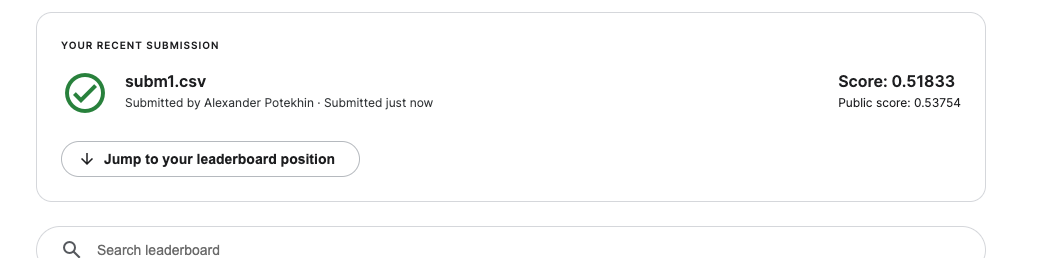

In [65]:
from IPython.display import Image
Image(filename='image.png') 